In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
file_name = "ca-netscience/ca-netscience.mtx"

In [2]:
G = nx.read_edgelist(file_name, nodetype=int)

In [3]:
num_nodes = G.number_of_nodes()
nx.info(G)

'Graph with 379 nodes and 914 edges'

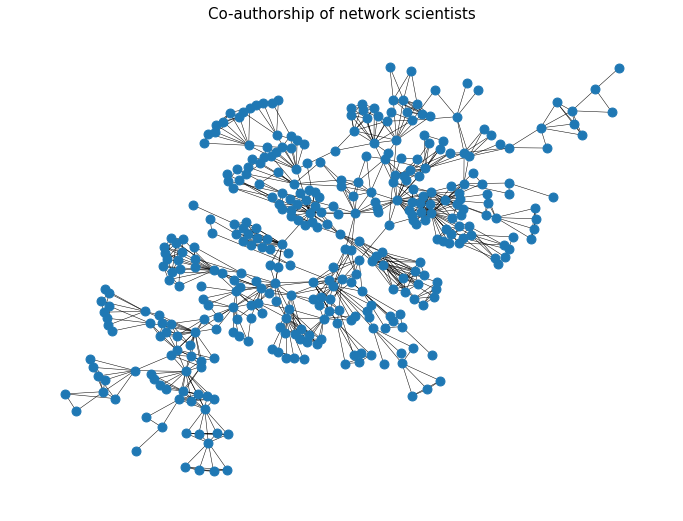

In [4]:
plt.figure(figsize=(12, 9))
plt.title("Co-authorship of network scientists", size=15)
nx.draw_kamada_kawai(G, node_size=80, width=0.5, with_labels=False)
plt.savefig("original_g.eps")

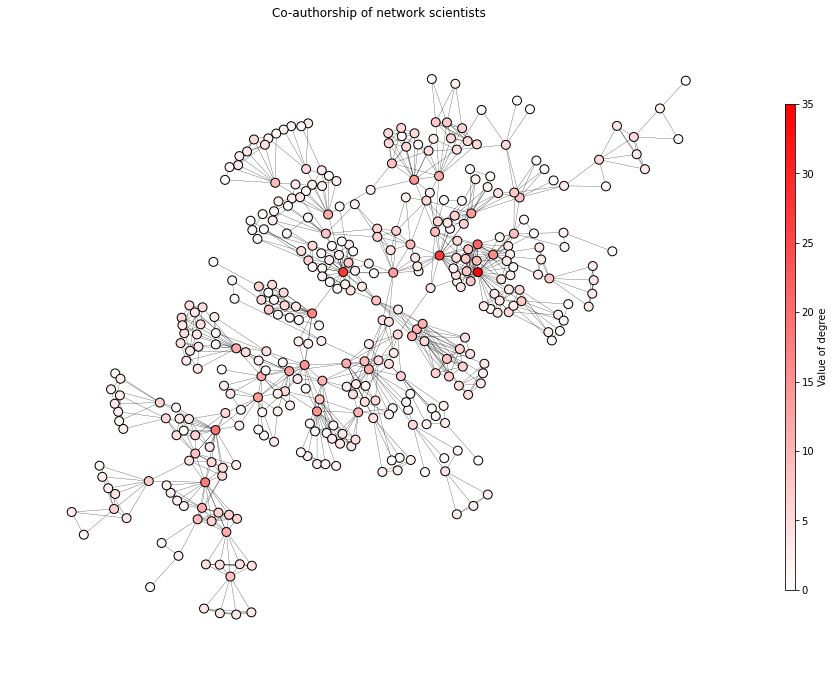

In [5]:
# Degree Centrality Plot
from matplotlib import cm, colors

node_color = [G.degree(n) for n in G.nodes()]
cmap = colors.LinearSegmentedColormap.from_list('', ['w','r'])

smap = cm.ScalarMappable(cmap=cmap)
smap.set_array([i for i in range(0, 36)])

plt.figure(figsize=(12, 9))
nx.draw_kamada_kawai(G, node_size=80, edgecolors='k', width=.25,
                node_color=node_color, cmap=cmap)
plt.colorbar(smap, aspect=50, label="Value of degree", fraction=0.1, pad=0.04, shrink=0.75)
plt.title("Co-authorship of network scientists")
plt.savefig("deg_heatmap.eps")
plt.show()

In [6]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.figure(figsize=(12, 9))
    plt.title("Degree Distribution of the Network", size=15)
    hist_, bins_, _ = plt.hist(degrees, density=1, rwidth=0.5, bins = np.linspace(0, 40, 41))
    plt.xlabel("Degree", size=10)
    plt.ylabel("Frequency", size=10)
    plt.savefig("Degree_dist.eps")
    plt.show()
    return (hist_, bins_)

def plot_cumu_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.figure(figsize=(12, 9))
    plt.title("Degree Distribution of the Network", size=15)
    hist_, bins_, _ = plt.hist(degrees, density=1, cumulative=-1, bins = np.linspace(0, 40, 41), edgecolor="k", fc=(0, 0, 0, 0.5), lw=3)
    plt.xlim(1, 40)
    plt.xlabel("Degree", size=10)
    plt.ylabel("Frequency", size=10)
    plt.xscale("log")
    plt.yscale("log")
    plt.show()
    return (hist_, bins_)

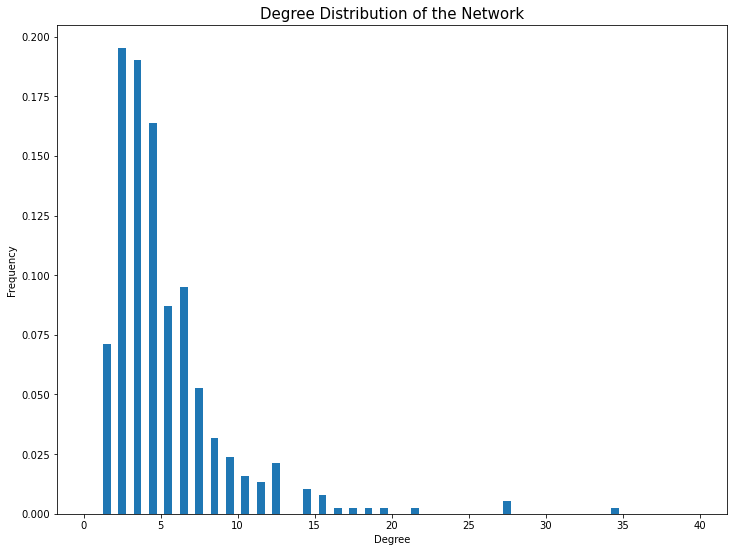

In [7]:
a, b = plot_degree_dist(G)

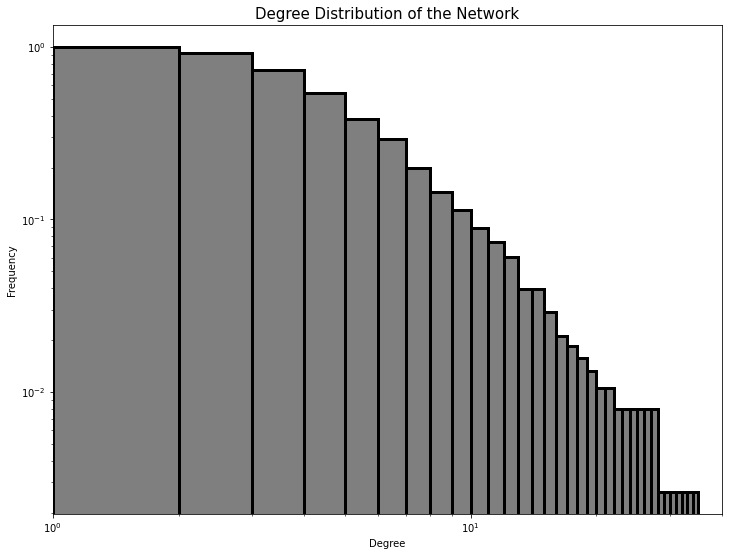

In [8]:
hist, bins = plot_cumu_dist(G)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


112.022 -3.059


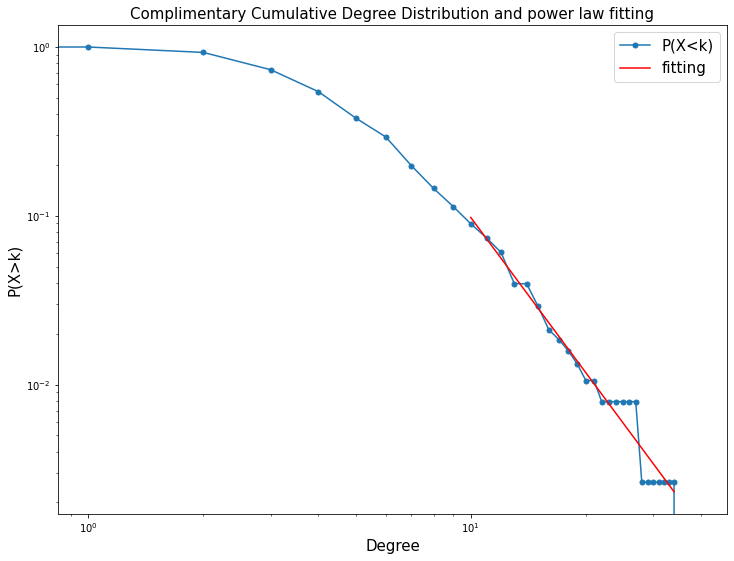

In [9]:
# Power law
from scipy.stats import linregress

def power_law_func(k, slope, intercept):
    return np.exp(intercept) * k**slope

tail_hist = []
tail_bins = []
for i in range(10, len(hist)):
    if hist[i] != 0:
        tail_hist.append(hist[i])
        tail_bins.append(bins[i])

        
lg_hist = np.log(tail_hist)
lg_bins = np.log(tail_bins)
fitting_res = linregress(lg_bins, lg_hist)
fit_line = power_law_func(tail_bins, fitting_res.slope, fitting_res.intercept)
coef = "%.3f" % np.exp(fitting_res.intercept)
exp_num = "%.3f" %  fitting_res.slope
print(coef, exp_num)
plt.figure(figsize=(12, 9))
plt.plot(bins[:-1], hist, marker=".", markersize=10, label="P(X<k)")
plt.plot(tail_bins, fit_line, "r", label="fitting")
plt.title("Complimentary Cumulative Degree Distribution and power law fitting", size=15)
plt.xlabel("Degree", size=15)
plt.ylabel("P(X>k)", size=15)
plt.xscale("log")
plt.yscale("log")
plt.legend(prop={'size': 15})
plt.savefig("cumu_deg.eps")
plt.show()

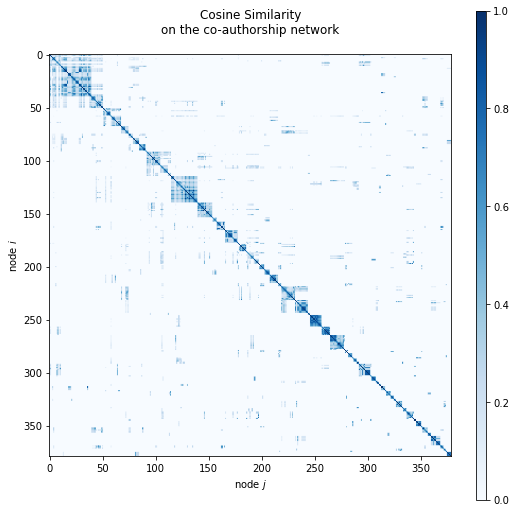

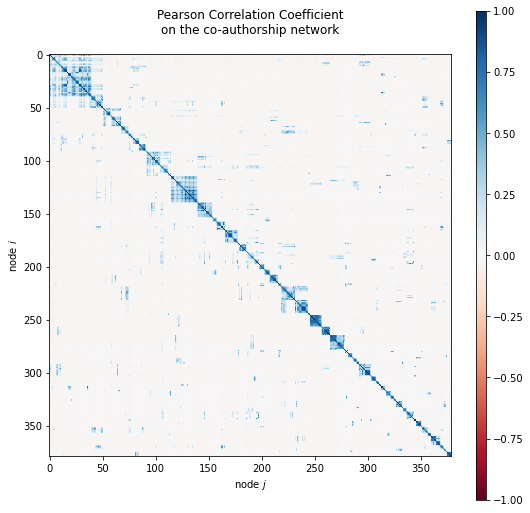

In [10]:
# Similarity
def cosine_similarity(G):
    A = nx.to_numpy_array(G)
    k = A.sum(1).reshape(-1, 1)
    return A@A/np.sqrt(k@k.T)

plt.figure(figsize=(9, 9))
plt.imshow(cosine_similarity(G),
           cmap='Blues', vmin=0, vmax=1)
plt.xlabel(r'node $j$')
plt.ylabel(r'node $i$')
plt.title('Cosine Similarity\non the co-authorship network\n')
plt.colorbar(aspect=50)
plt.savefig("cos_sim.eps")
plt.show()

def pearson_correlation_coeffficient(G):
    A = nx.to_numpy_array(G)
    V = A.var(axis=1, ddof=0).reshape(-1, 1)
    return np.cov(A, ddof=0)/np.sqrt(V@V.T)

plt.figure(figsize=(9, 9))
plt.imshow(pearson_correlation_coeffficient(G),
           cmap='RdBu', vmin=-1, vmax=1)
plt.xlabel(r'node $j$')
plt.ylabel(r'node $i$')
plt.title('Pearson Correlation Coefficient\non the co-authorship network\n')
plt.colorbar(aspect=50)
plt.savefig("pearson_co.eps")
plt.show()

In [11]:
# from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import girvan_newman
partition_girvan_newman = girvan_newman(G)

In [12]:
G.graph['GN'] = list(partition_girvan_newman)

In [13]:
from matplotlib.cm import gist_rainbow_r as rainbow_map

In [14]:
def generate_node_color(cur_G, gn_idx):
    num_comm = len(cur_G.graph['GN'][gn_idx])
    color_list = list(map(rainbow_map, [i/num_comm for i in range(0, num_comm)]))
    node_clr = []
    for n in cur_G:
        for i in range(0, num_comm):
            if n in cur_G.graph['GN'][gn_idx][i]:
                node_clr.append(color_list[i])
                break
    return node_clr

In [15]:
def draw_comm(cur_G, num_comm, fig_size=(12, 9)):
    tmp_cmap = generate_node_color(cur_G, num_comm-2)
    plt.figure(figsize=fig_size)
    plt.title("Co-authorship of network scientists", size=25)
    nx.draw_kamada_kawai(G, node_size=80, width=0.5, edgecolors='k',
                        node_color=tmp_cmap)
    plt.title("Group the network into " + str(num_comm) + " communities")
    plt.savefig("comm_"+str(num_comm)+".eps")
    plt.show()

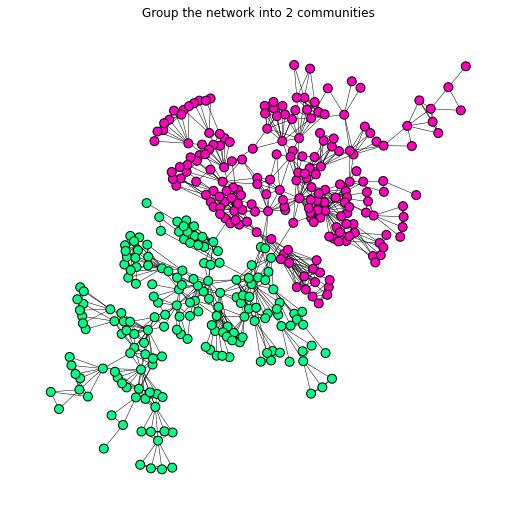

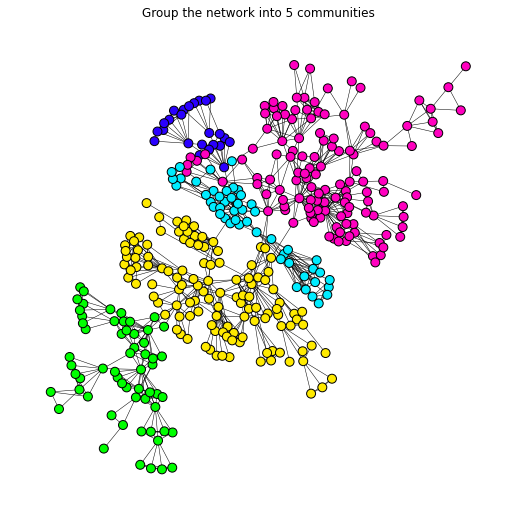

In [16]:
draw_comm(G, 2, (9, 9))
draw_comm(G, 5, (9, 9))


In [17]:
import networkx.algorithms.community as nx_comm

n_axis = [len(group) for group in G.graph['GN']]
modul_list = []
for group in G.graph['GN']:
    modul_list.append(nx_comm.modularity(G, group))

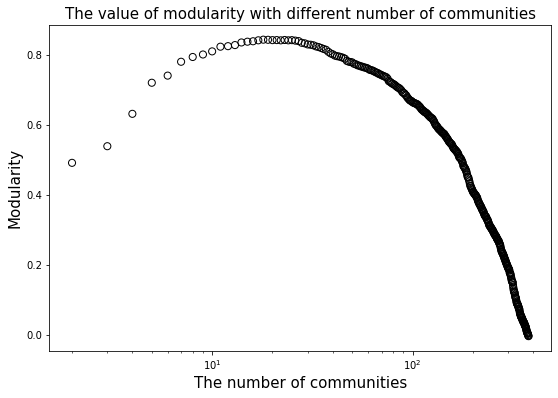

In [18]:
plt.figure(figsize=(9,6))
plt.title("The value of modularity with different number of communities", size=15)
plt.scatter(n_axis, modul_list, s=50, facecolors='none', edgecolors='k')
plt.xscale("log")
plt.xlabel("The number of communities", size=15)
plt.ylabel("Modularity", size=15)
plt.savefig("modul.eps")
plt.show()

The highest value of modularity is: 0.8440428251990674


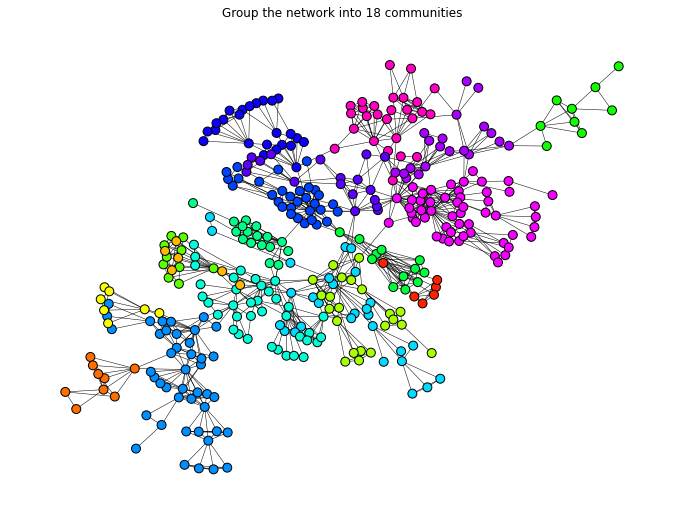

In [19]:
print("The highest value of modularity is:", max(modul_list))
best_partition = n_axis[np.argmax(modul_list)]
draw_comm(G, best_partition)

In [20]:
clst_coeff = nx.average_clustering(G)
print(clst_coeff)

0.7412306142925664


In [21]:
avg_shortest_path = nx.average_shortest_path_length(G)

In [22]:
print(avg_shortest_path)

6.041867347935949


In [23]:
import random as rd
import copy
n_repeated = 50
phi = np.linspace(0, 1, num_nodes+1, endpoint=True)

def get_max_component_size(G):
    cmpnts = list(nx.connected_components(G))
    ans = 0
    for i in cmpnts:
        if len(i) > ans:
            ans = len(i)
    return ans

In [24]:
# Attack
def random_attack(G):
    copy_G = copy.deepcopy(G)
    remove_order = [i+1 for i in range(0, num_nodes)]
    rd.shuffle(remove_order)
    ans = [get_max_component_size(copy_G)]
    for r_node in remove_order:
        copy_G.remove_node(r_node)
        ans.append(get_max_component_size(copy_G))
    return ans

def target_attack(G):
    copy_G = copy.deepcopy(G)
    remove_order = [node_deg[0] for node_deg in sorted(list(G.degree), reverse=True,key=lambda x: x[1])]
    ans = [get_max_component_size(copy_G)]
    for r_node in remove_order:
        copy_G.remove_node(r_node)
        ans.append(get_max_component_size(copy_G))
    return ans

In [25]:
s_arr_random = []
for i in range(n_repeated):
    s_arr_random.append(random_attack(G))
s_r_random = np.mean(s_arr_random, axis=0)
s_r_target = target_attack(G)

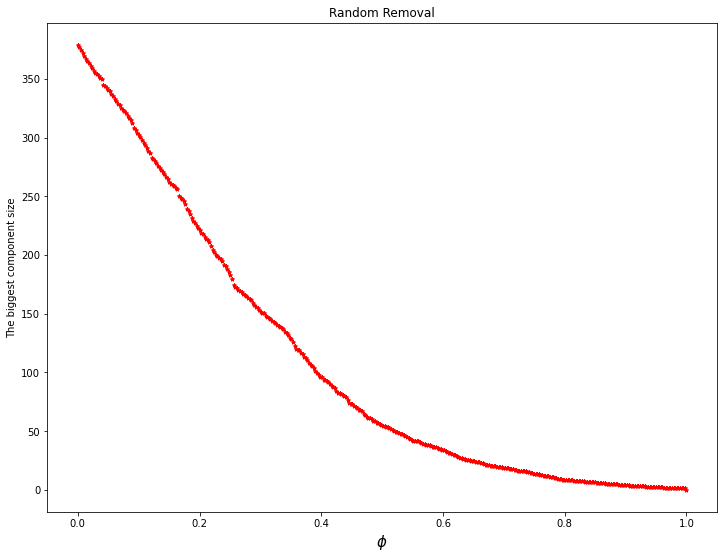

In [26]:
plt.figure(figsize=(12, 9))
plt.scatter(phi, s_r_random, s=15, marker="*", color="r")
plt.title("Random Removal")
plt.xlabel(r"$\phi$", size=15)
plt.ylabel("The biggest component size")
plt.show()

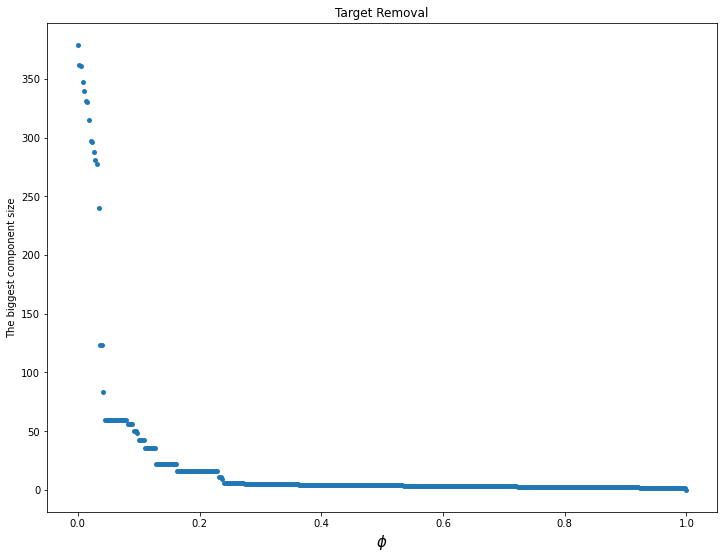

In [27]:
plt.figure(figsize=(12, 9))
plt.scatter(phi, s_r_target, s=15)
plt.title("Target Removal")
plt.xlabel(r"$\phi$", size=15)
plt.ylabel("The biggest component size")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


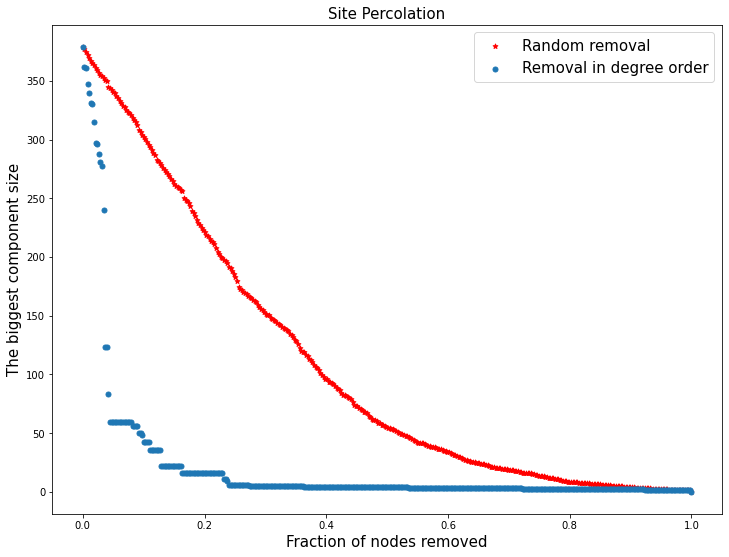

In [34]:
plt.figure(figsize=(12, 9))
plt.scatter(phi, s_r_random, s=25, marker="*", color="r", label="Random removal")
plt.scatter(phi, s_r_target, s=25, label="Removal in degree order")
plt.xlabel("Fraction of nodes removed", size=15)
plt.ylabel("The biggest component size", size=15)
plt.title("Site Percolation", size=15)
plt.legend(prop={'size': 15})
plt.savefig("attack.eps")
plt.show()

In [29]:
from scipy.cluster import hierarchy
def to_linkage(tuples_of_sets, height='rank'):
    N = len(tuples_of_sets[0])
    Z = np.zeros((N-1,4), float)
    record = list(tuples_of_sets[0])
    
    for i in range(N-2):
        idxs,sets = [],[]
        for set_ in tuples_of_sets[i]:
            if set_ not in tuples_of_sets[i+1]:
                idxs.append(record.index(set_))
                sets.append(set_)
        record += [sets[0].union(sets[1])]
        Z[i,:2] = idxs
        Z[i,-1] = len(record[-1])
    Z[-1,:2] = [record.index(set_) for set_ in tuples_of_sets[-1]]
    Z[-1,-1] = N
    
    if height == 'rank':
        track = sorted(list(set(Z[:,3])))
        Z[:,2] = [track.index(Z[i,3])+1 for i in range(N-1)]
    else: # height == 'size'
        Z[:,2] = Z[:,3]-1
    return Z

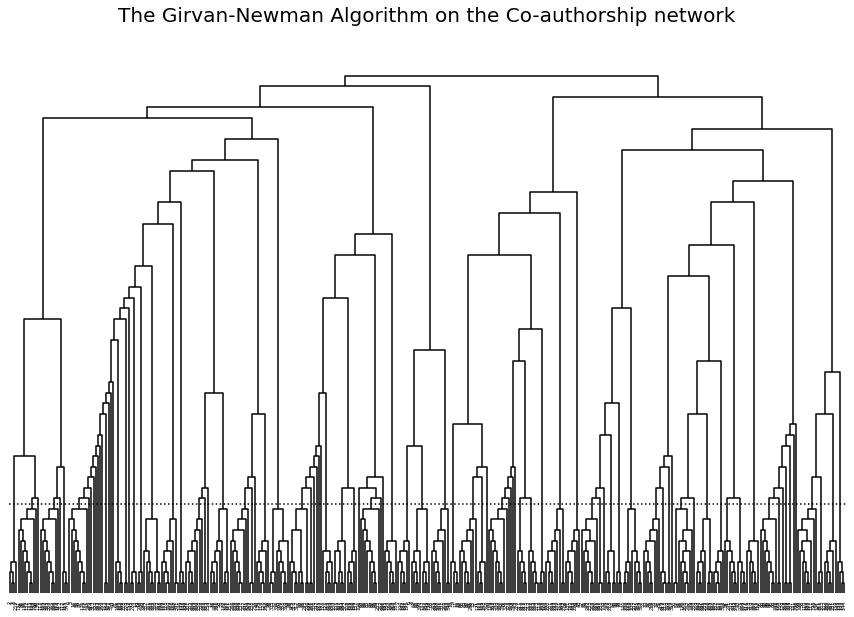

In [30]:
plt.figure(figsize=(15,10))
plt.title('The Girvan-Newman Algorithm on the Co-authorship network\n', size=20)
hierarchy.dendrogram(to_linkage(G.graph['GN'][::-1]), labels=list(G),
                     color_threshold=0, above_threshold_color='k')
plt.axhline(8.5, c='k', ls=':')
plt.gca().yaxis.set_visible(False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.savefig("hier.eps")

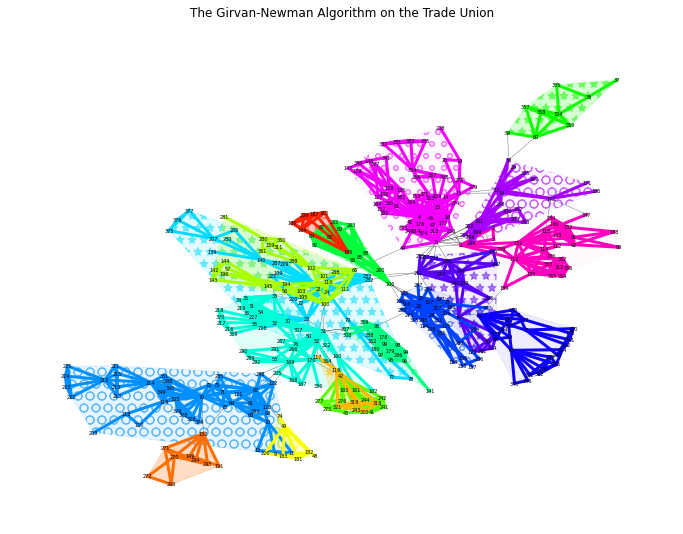

In [31]:
# the gift-wrapping algorithm; for visualizing communities
def gift_wrap(pts):
    convexHull = []
    ptOnHull = pts[pts[:,0].argmin(), :] # leftmost
    counter_clock = lambda a,b,c: (c[1]-a[1])*(b[0]-a[0]) \
                               >= (b[1]-a[1])*(c[0]-a[0]) # cross product
    while True:
        convexHull.append(ptOnHull)
        endpt = pts[0]
        for j in range(1, len(pts)):
            if np.allclose(endpt, ptOnHull) or \
            not counter_clock(pts[j], convexHull[-1], endpt):
                # pts[j] on the left of (convexHull[-1], endpt)
                endpt = pts[j]
        ptOnHull = endpt
        if np.allclose(endpt, convexHull[0]):
            return np.array(convexHull)
N = len(G.graph['GN'][16])

cmap = rainbow_map

plt.figure(figsize=(12,9))
plt.title('The Girvan-Newman Algorithm on the Trade Union\n')
G.graph['pos'] = dict((n,c[::-1]) for n,c in nx.kamada_kawai_layout(G).items())
for i,C in enumerate(G.graph['GN'][16]):
    pts = np.array(list(G.graph['pos'][n] for n in C))
    xy = gift_wrap(pts).T
    plt.fill(*xy, c=cmap(i/N), alpha=.25*(1+i)/N)
    plt.fill(*xy, fc='none', ec=cmap(i/N), lw=0,
             alpha=.5, hatch=['','o','O','*'][i%4])
    idxs = dict((n, idx) for idx,n in enumerate(C))
    for (u,v) in nx.subgraph(G, C).edges:
        plt.plot(*pts[[idxs[u],idxs[v]]].T, '-', c=cmap(i/N), lw=3)

nx.draw(G, pos=G.graph['pos'], node_size=0, width=.25)
for bbox,N in nx.utils.groups(dict(G.nodes(data='bbox'))).items():
    labels = dict((n,n) for n in N)
    nx.draw(G, pos=G.graph['pos'],
            node_size=0, width=0, labels=labels, font_size=5)